In [1]:
import cv2
import numpy as np
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
import sys
import os
from matplotlib import pyplot as plt
import imutils

preprocess: conversión a escala de grises, mejoramiento de contraste, filtro bilateral, binarización otzu

In [2]:
def preprocess(img, showing):
    #convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #improve the contrast of our images
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
    darker = clahe.apply(gray)
    #Blurring to remove noise
    blurred = cv2.bilateralFilter(darker,9,75,75)
    #Threshold
    ret,otsu = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if showing==True:
        titles = ['gray', 'darker','blurred','otsu']
        images = [gray, darker, blurred, otsu]
        subplot(titles, images, 2, 2, 35)    
    return otsu

In [3]:
def plotImage(img, size):
    fig, ax = plt.subplots(figsize=(size,size))
    plt.imshow(img)
    plt.xticks([]),plt.yticks([])
    plt.show()

In [4]:
def subplot(titles, images, rows, imgPerRows, size):
    fig, ax = plt.subplots(figsize=(size,size))
    for i in range(len(images)):
        plt.subplot(rows,imgPerRows,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()

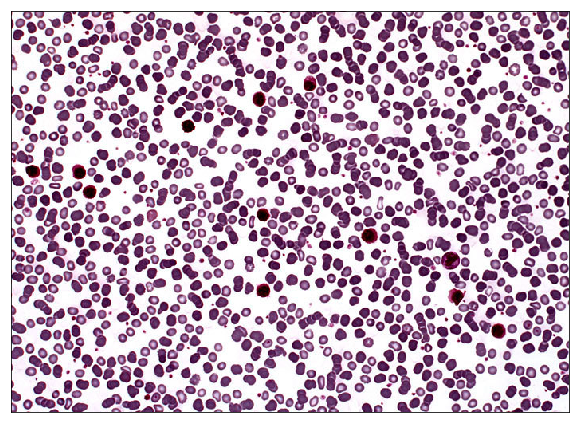

In [5]:
#image  = cv2.imread("resources/cell3.jpg")
#image  = cv2.imread("resources/pathology_cll40x03.jpg")
image  = cv2.imread("resources/pathology_cll20x01.jpg")

img_copy = image.copy()
num =0
listWhiteBloodCells = []
plotImage(image,10)

Preprocesamiento: grayscale, equalizacion de histograma adaptativo, filtro bilateral y otsu

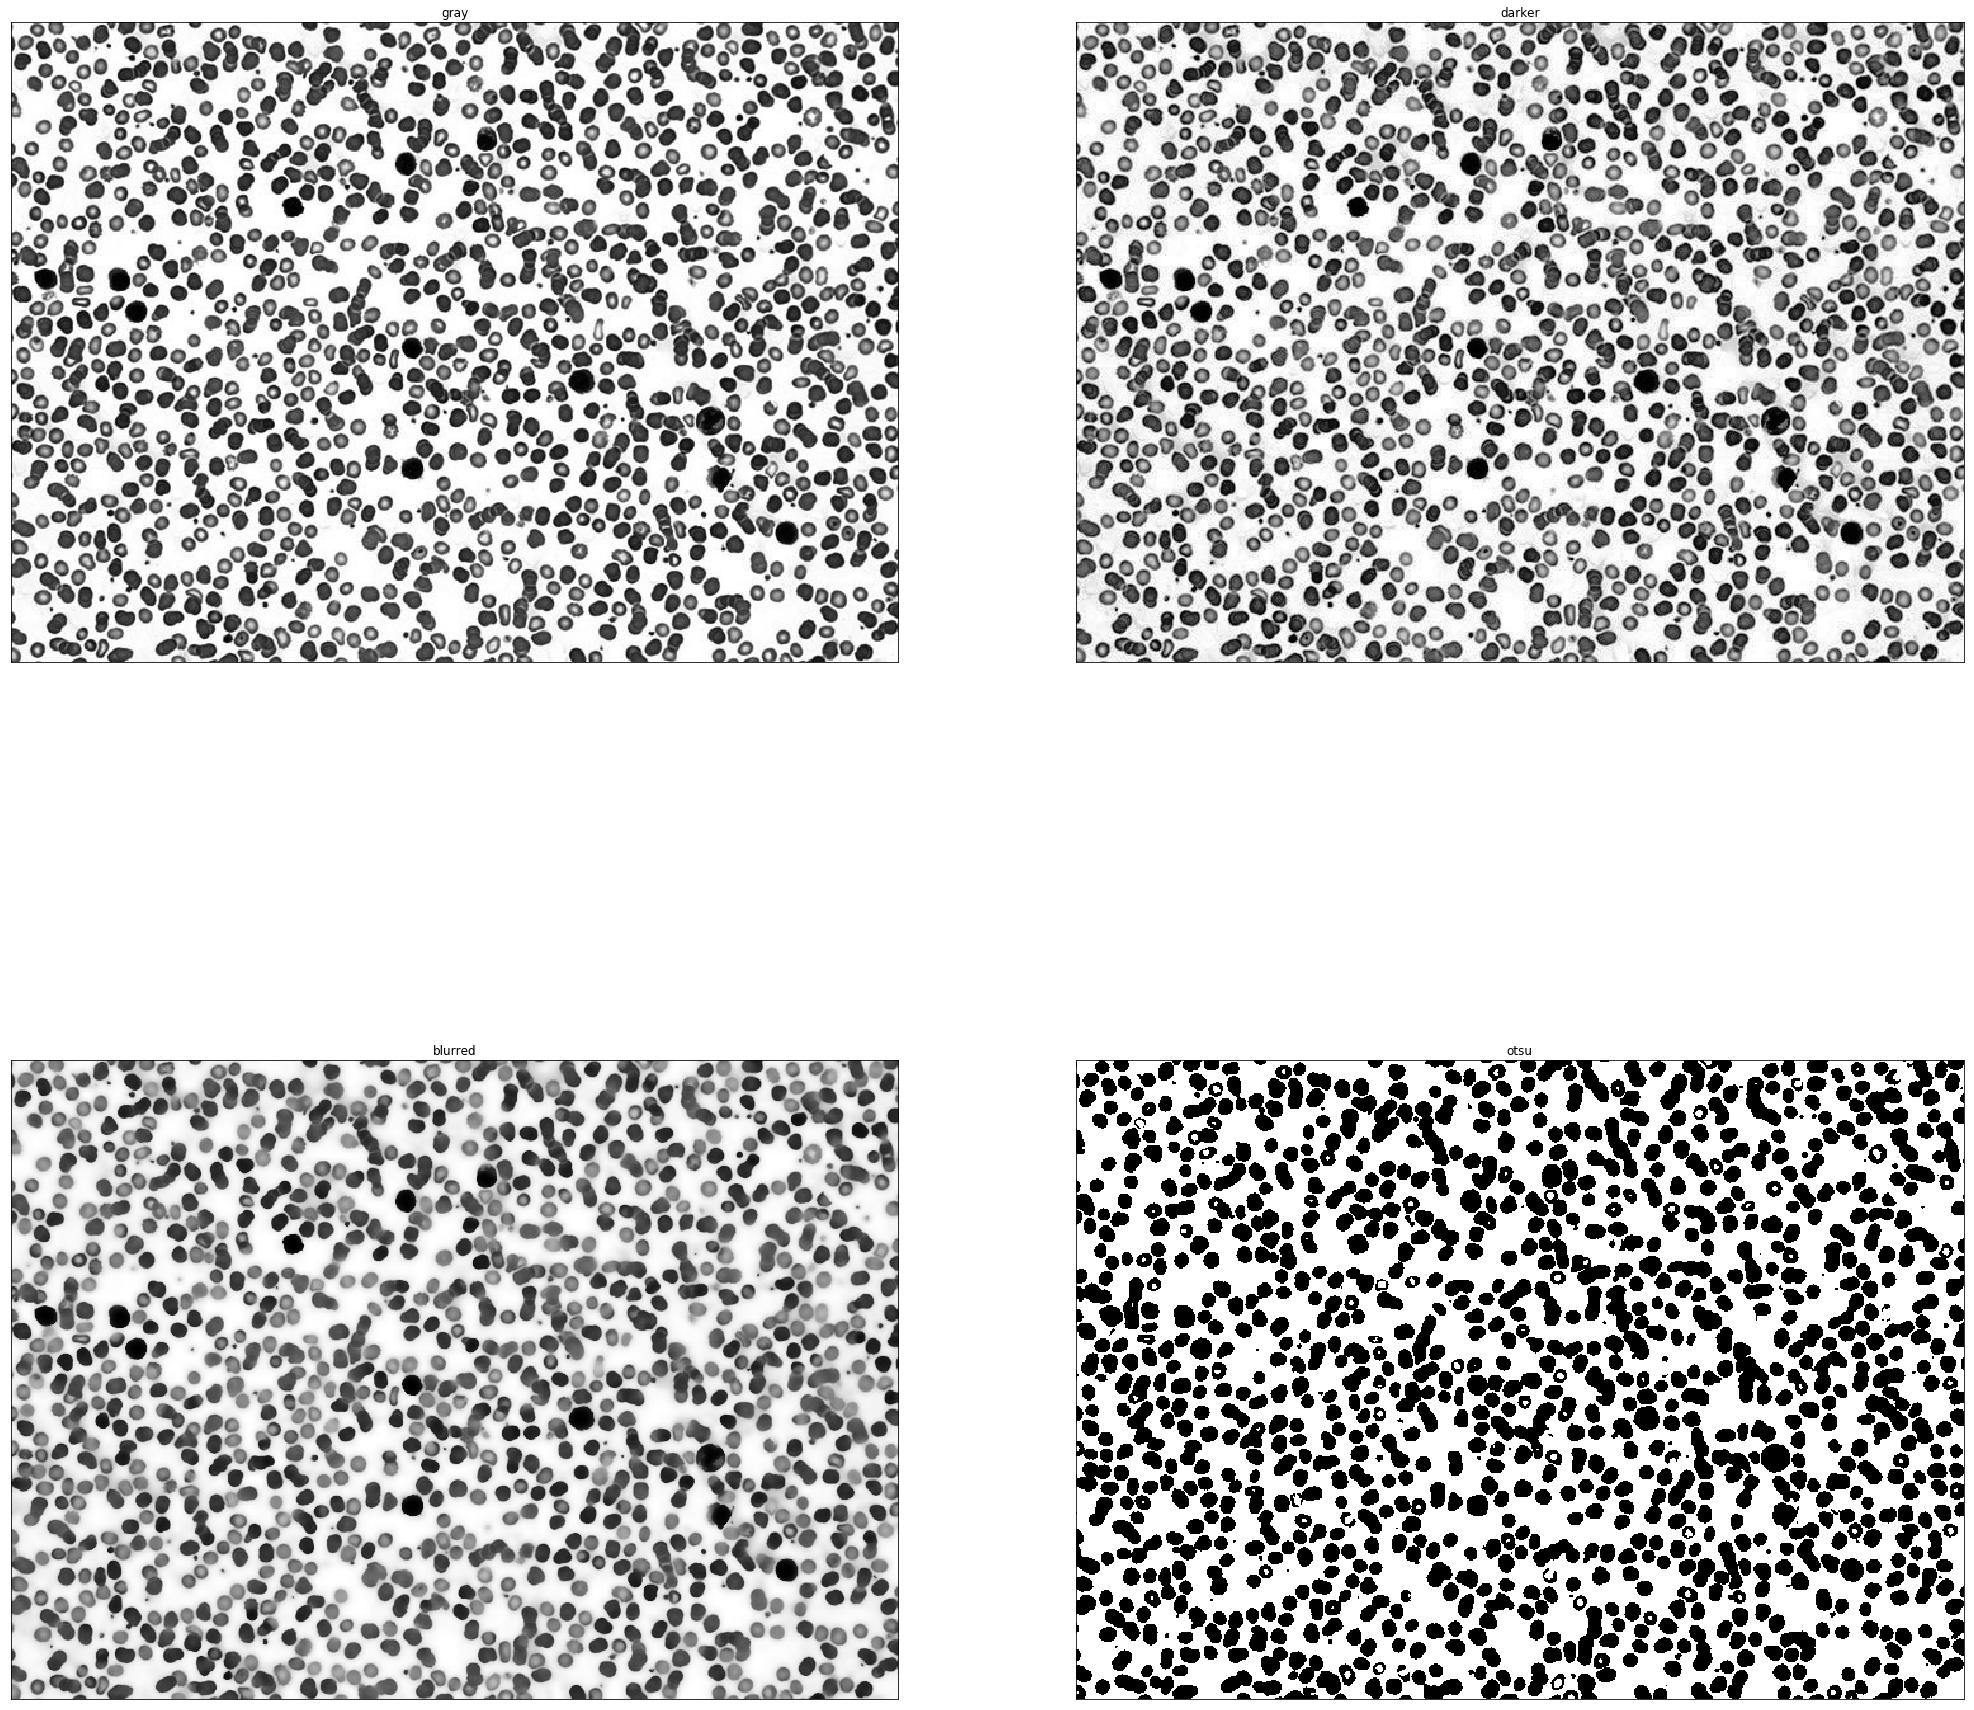

In [6]:
otsu = preprocess(image, True)

Inversión de píxeles y detección de contornos

In [7]:
#invert
newimg = cv2.bitwise_not(otsu)
newimg1 = cv2.bitwise_not(otsu)
#find contours of newimg
im2, contours, hierarchy = cv2.findContours(newimg,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#filling the "holes" of the cells
for cnt in contours:
    cv2.drawContours(newimg,[cnt],0,255,-1)


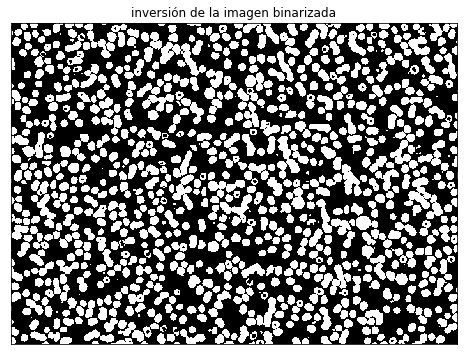

In [8]:
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(newimg1,'gray')
plt.title('inversión de la imagen binarizada')
plt.xticks([]),plt.yticks([])
plt.show()

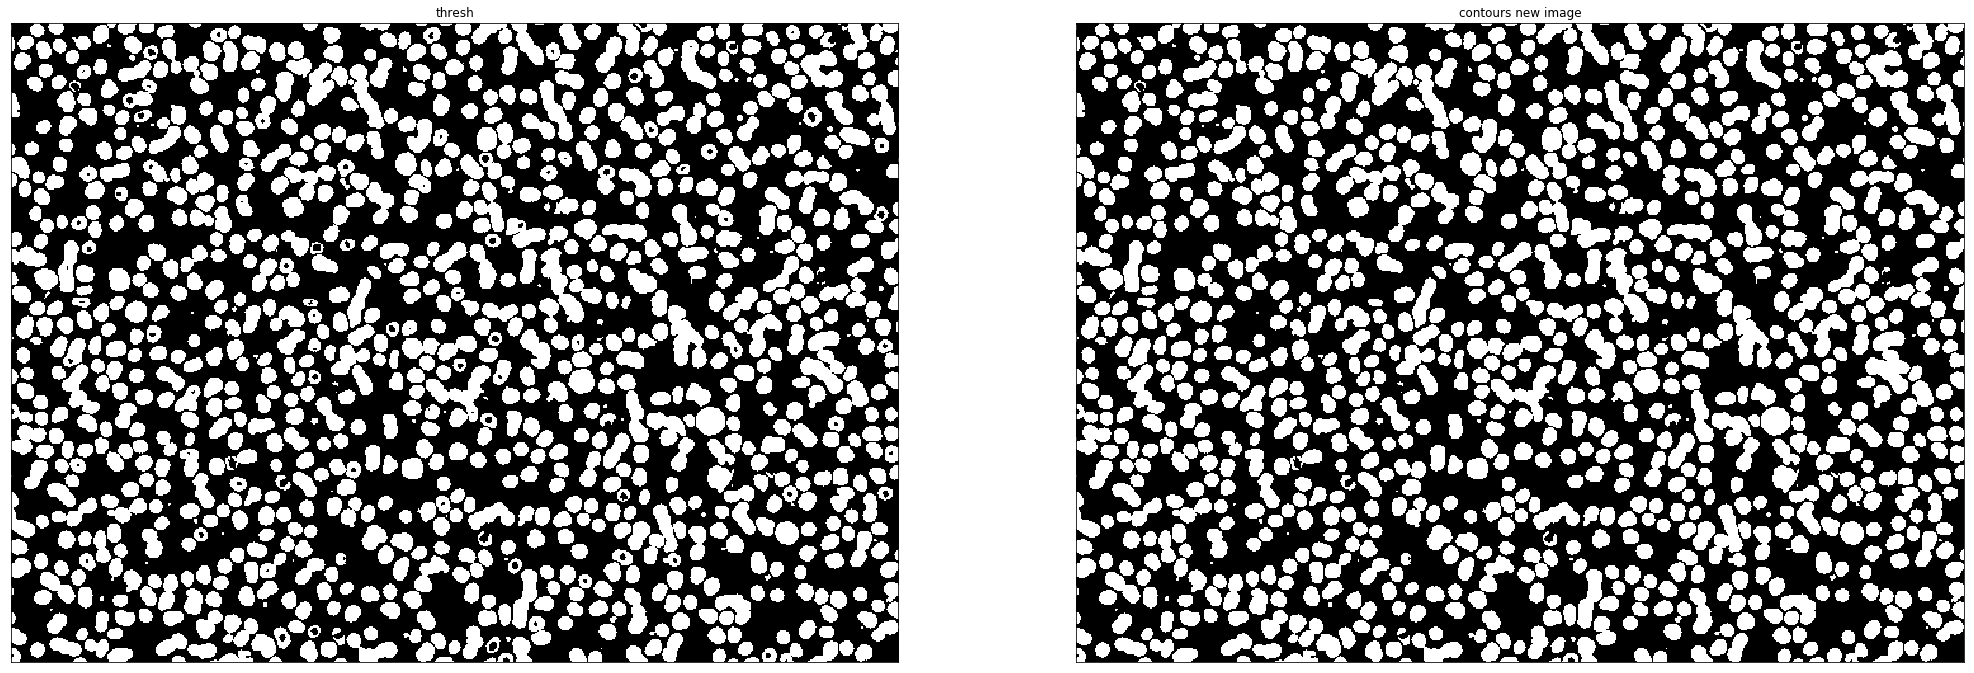

In [9]:
titles = ['thresh', 'contours new image']
images = [newimg1, newimg]
subplot(titles, images, 1, 2, 35)


Ubicación de centroides, marcado y aplicación del algoritmo watershed

In [10]:
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(newimg)
localMax = peak_local_max(D, indices=False, min_distance=5,labels=newimg)
 



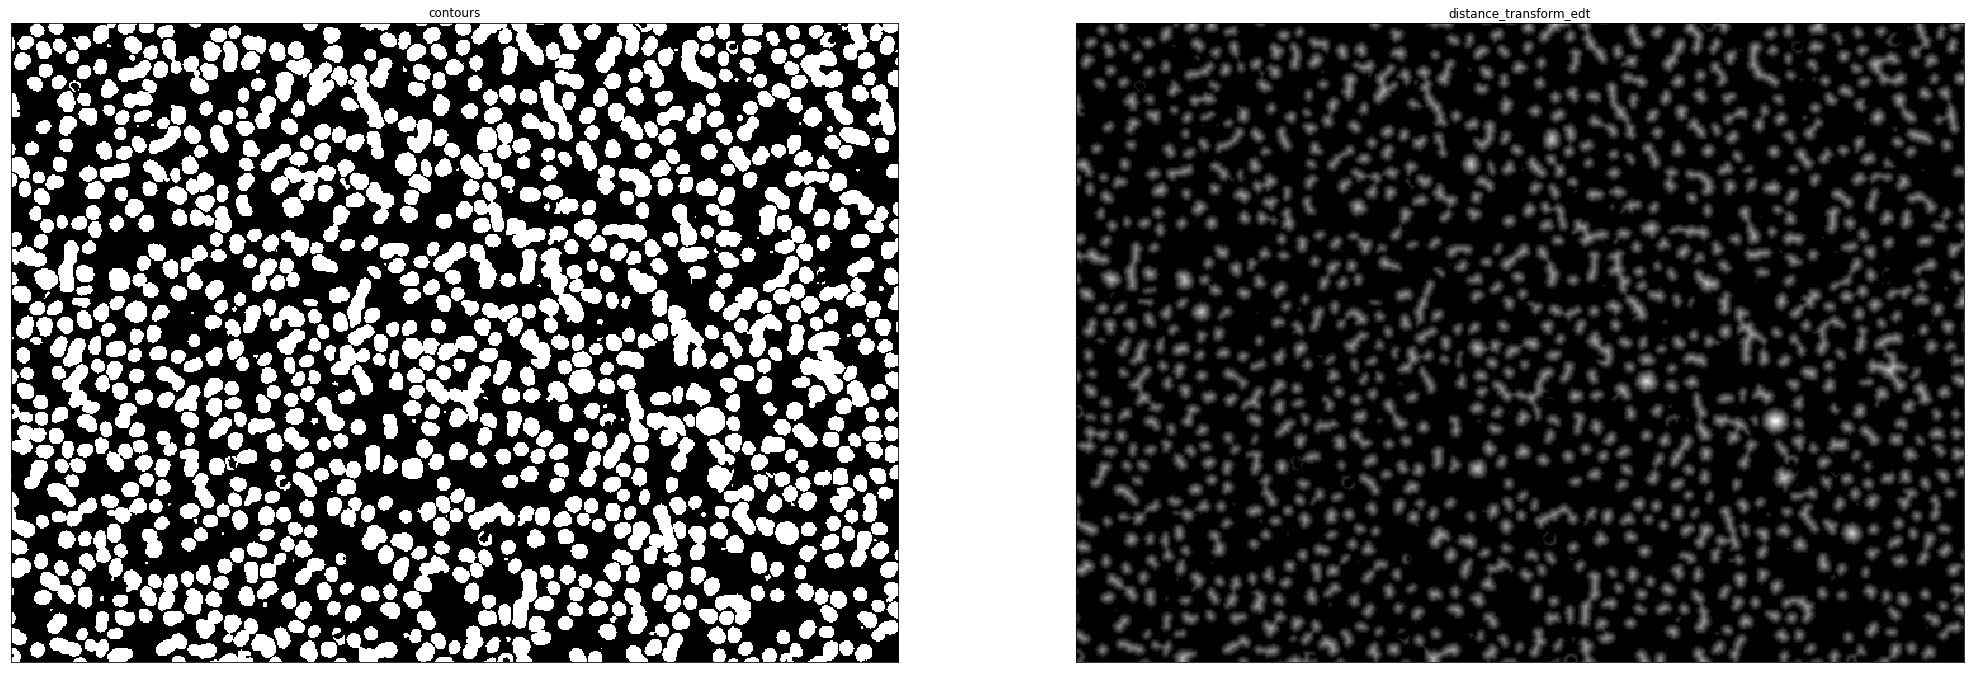

In [11]:
titles = ['contours', 'distance_transform_edt']
images = [newimg, D]
subplot(titles, images, 1, 2, 35)

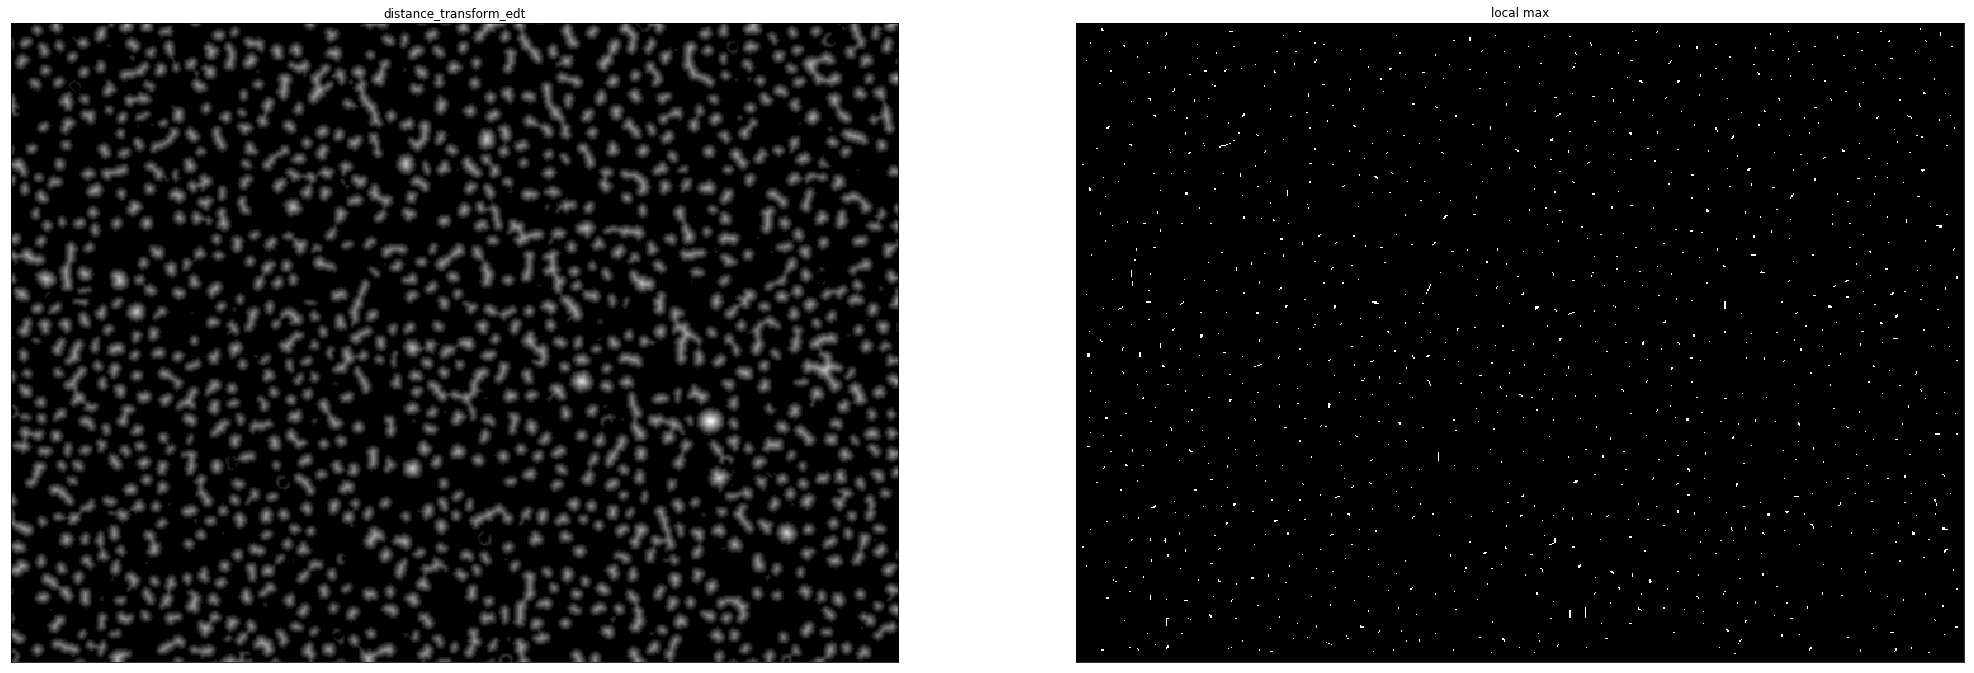

In [12]:
titles = ['distance_transform_edt', 'local max']
images = [D, localMax]
subplot(titles, images, 1, 2, 35)

 marcado y aplicación del algoritmo watershed

In [13]:
# perform a connected component analysis on the local peaks,
# then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]

#Since the watershed algorithm assumes our markers represent local minima (i.e., valleys) in our distance map, we take the negative value of D
labels = watershed(-D, markers, mask=newimg)

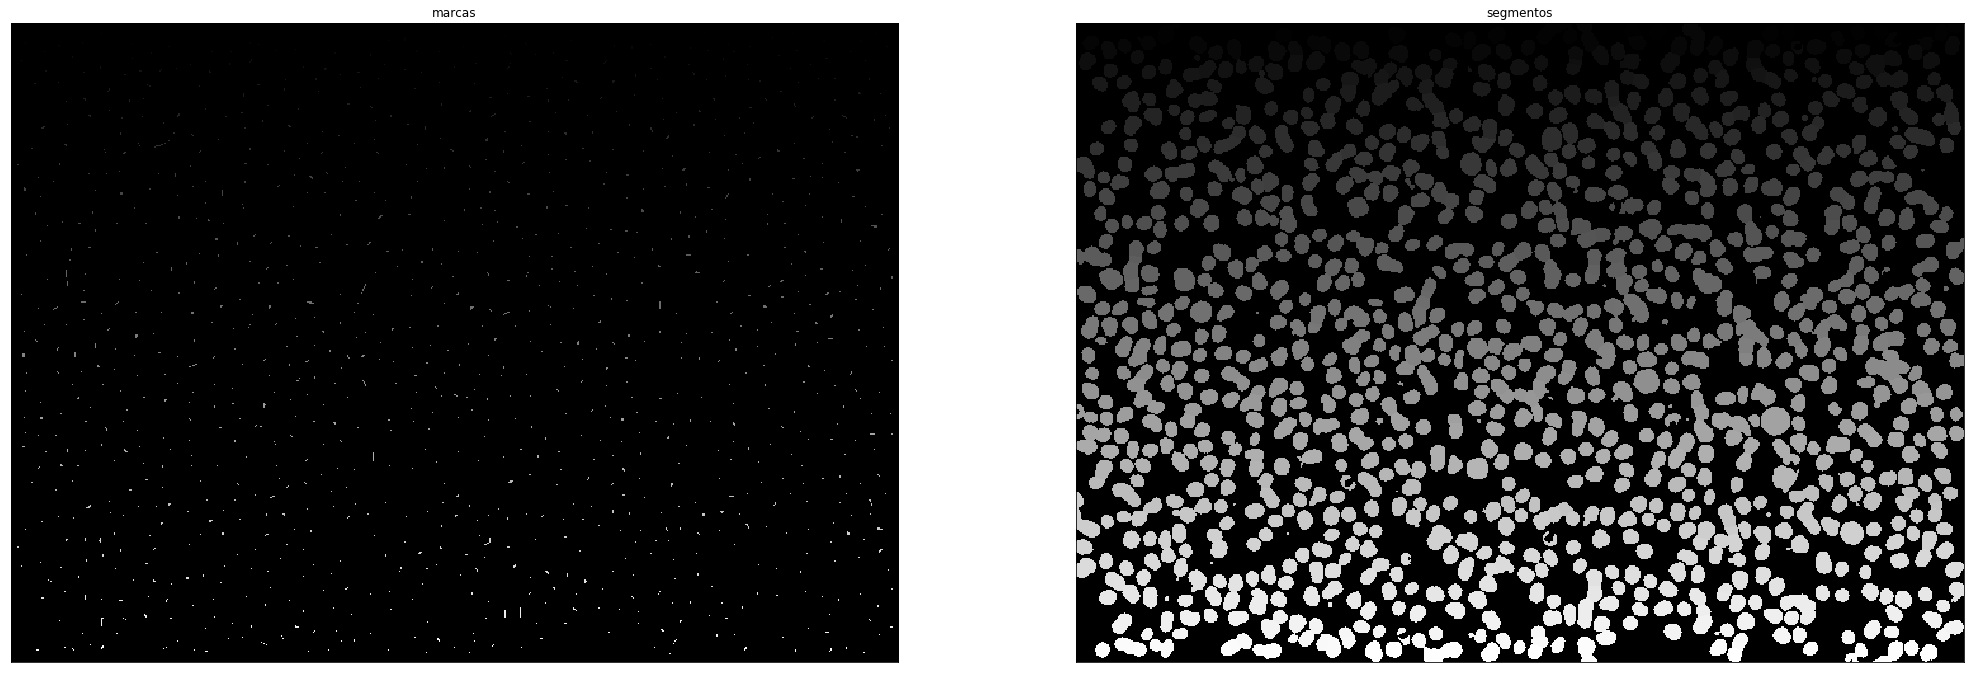

In [14]:
titles = ['marcas', 'segmentos']
images = [markers, labels]
subplot(titles, images, 1, 2, 35)

In [15]:
# loop over the unique labels returned by the Watershed algorithm
listROI = []

num = 0
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    if label == 0:
        continue
 
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(otsu.shape, dtype="uint8")
    mask[labels == label] = 255
 
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    c = max(cnts, key=cv2.contourArea)

    
    #saving every single cell as a rectangular image.
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img_copy,(x,y),(x+w,y+h),(0,255,0),2)
    roi = image[y:y+h, x:x+w]
    listROI.append(roi)
    num = num + 1

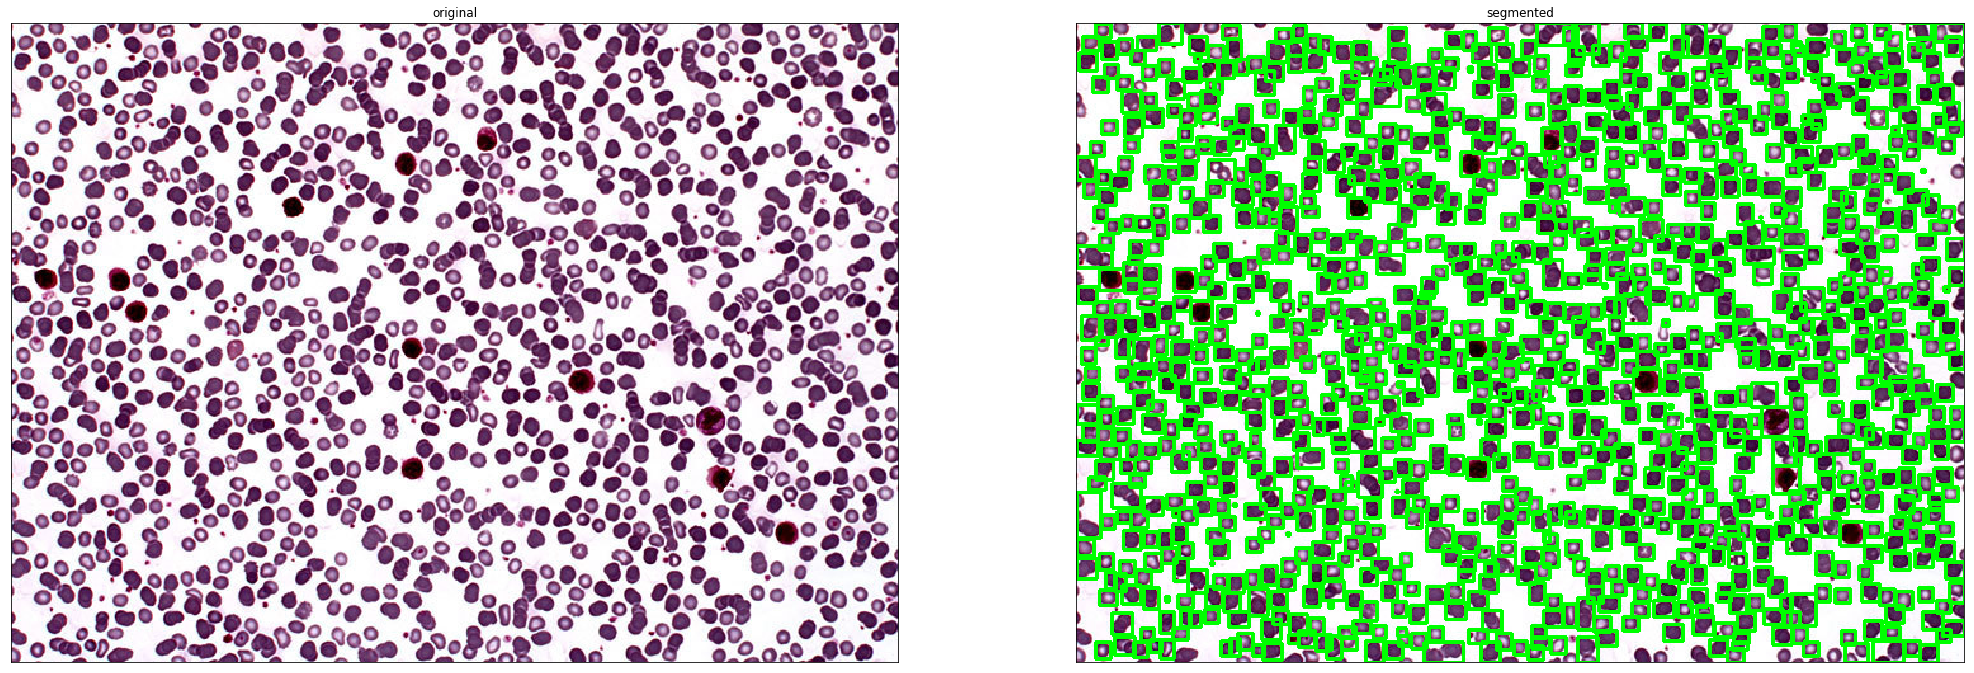

In [16]:
titles = ['original', 'segmented']
images = [image, img_copy]
subplot(titles, images, 1, 2, 35)

In [17]:
print(num )
print(len(listROI))
    

1132
1132


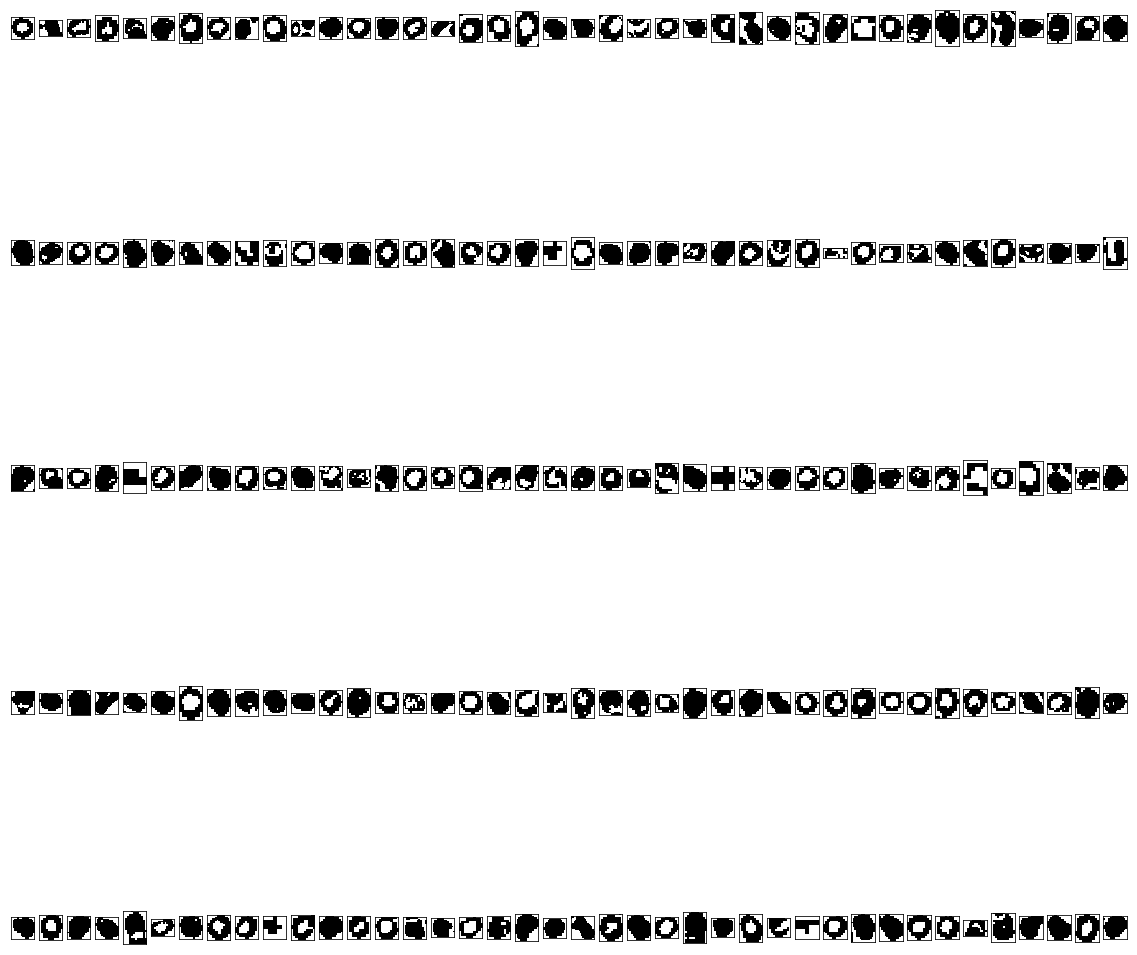

In [18]:
images = [image, img_copy]
fig, ax = plt.subplots(figsize=(20,20))
for i in range(200):
    plt.subplot(5,40,i+1),plt.imshow(preprocess(listROI[i], False),'gray')
    plt.title("")
    plt.xticks([]),plt.yticks([])
plt.show()

Preprocesamiento: grayscale, equalizacion de histograma adaptativo, filtro bilateral y otsu

In [19]:
for i in range(len(listROI)):
    roiElement = listROI[i]
    preProcElement = preprocess(roiElement, False)
    rows, cols = np.shape(preProcElement)
    evaluatedPixel = preProcElement[int(rows/2),int(cols/2)]
    if evaluatedPixel==255:
        listWhiteBloodCells.append(roiElement)
        
print(len(listWhiteBloodCells))

527


In [20]:
percentage = (len(listWhiteBloodCells)/len(listROI))*100
print("PERCENTAGE OF WHITE BLOOD CELLS: "+str(round(percentage, 2))+"%")

PERCENTAGE OF WHITE BLOOD CELLS: 46.55%


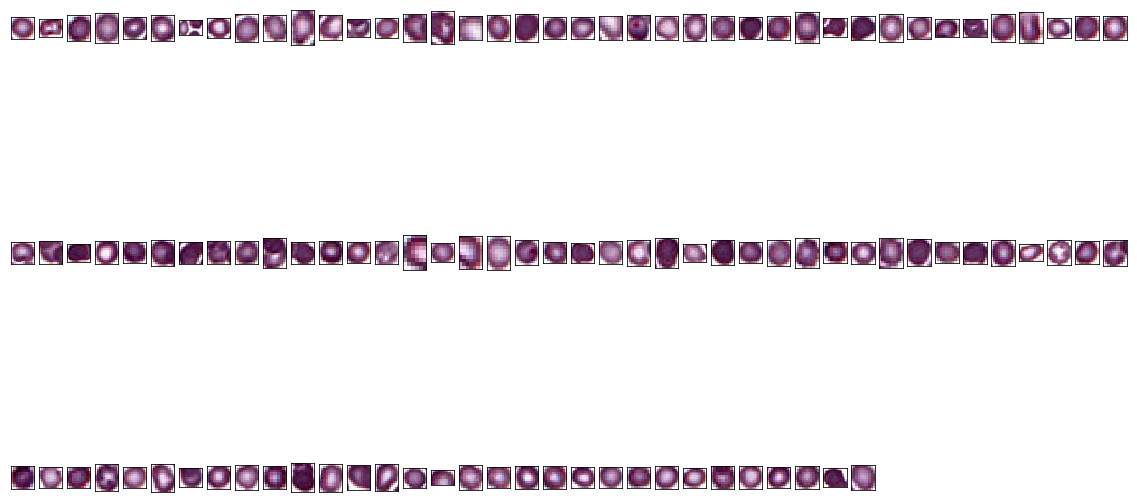

In [21]:
fig, ax = plt.subplots(figsize=(20,20))
for i in range(111):
    plt.subplot(5,40,i+1),plt.imshow(listWhiteBloodCells[i])
    plt.title("")
    plt.xticks([]),plt.yticks([])
plt.show()